<a href="https://colab.research.google.com/github/worker2396/uni/blob/main/Copy_of_Czesc1_2022_Odkrywanie_modeli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wprowadzenie do eksploracji procesów (*process mining*)

Główną klasą problemów z dziedziny eksploracji procesów jest odkrywanie procesów na podstawie dzienników zdarzeń. 
Metody odkrywania procesów biznesowych z danych pozwalają na budowę modeli procesów biznesowych i zobrazowanie rzeczywistych działań zachodzących w organizacjach, a nie jedynie hipotetycznego modelu opracowanego przez analityków.

W celu odkrycia modelu potrzebujemy dziennik zdarzeń (*event log*). Taki dziennik może być dostępny bezpośrednio w systemie (wiele systemów w dzisiejszych czasach loguje zachodzące w nich zdarzenia w specjalnych formatach dzienników zdarzeń) lub może być być utworzony z danych dostępnych w naszych bazach danych:
  * w prosty sposób np. z danych o transakcjach w sklepie internetowym, czy zachowaniu użytkowników systemu (kiedy, co i przez kogo zostało kliknięte w systemie), lub 
  * w nieco bardziej skomplikowany sposób z danych nieustrukturyzowanych, takich jak np. e-maile, obraz z kamery itp. 

## Konfiguracja środowiska


## Pobranie przykładowych danych dla naszego logu

Aby móc odkryć model procesu potrzebujemy danych, na bazie których będziemy próbowali ten model skonstruować. Dane możemy albo wczytywać bezpośrednio z serwera albo pobrać je i wczytywać z lokalnego pliku. 

Ponieważ plik z naszymi danymi dot. procesu napraw telefonów nie jest bardzo duży spróbujmy go pobrać w celu późniejszego przetwarzania. 

In [95]:
!wget http://home.agh.edu.pl/~kluza/repairExample.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


## Importowanie modułów

W celu odkrycia napisania prostego programu odkrywającego prototyp modelu procesu skorzystamy z kilku dostępnych modułów dla języka Python:

In [96]:
import pandas as pd
from functools import reduce
from itertools import groupby
from itertools import chain
from more_itertools import pairwise
from collections import Counter
import pygraphviz as pgv
from IPython.display import Image, display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [97]:

slider1 = widgets.IntSlider(
    value=0,
    min=0,
    max=1400,
    step=1,
    description='Filter by tasks:',
    readout_format='d'
)


In [98]:
slider2 = widgets.IntSlider(
    value=0,
    min=0,
    max=1200,
    step=1,
    description='Filter by trace:',
    readout_format='d'
)

In [99]:
display(slider1)
print(slider1.value)
filter1 = slider1.value


IntSlider(value=0, description='Filter by tasks:', max=1400)

0


In [100]:
display(slider2)
print(slider2.value)
filter2 = slider2.value


IntSlider(value=0, description='Filter by trace:', max=1200)

0


##Wczytanie danych

Wczytaj dane z pliku csv i przejrzyj je, a następnie używając funkcji z narzędzia pandas spróbuj odpowiedzieć na pytania związane z dziennikiem zdarzeń.

In [101]:
df = pd.read_csv('A1.csv')
df.head(10)

,Case ID,Activity,Start Timestamp
0,1,b,01.04.21 22:10
1,1,c,01.04.21 22:11
2,1,d,01.04.21 22:12
3,1,e,01.04.21 22:13
4,2,b,01.04.21 22:10
5,2,c,01.04.21 22:11
6,2,e,01.04.21 22:12
7,2,d,01.04.21 22:13
8,3,a,01.04.21 22:10
9,3,c,01.04.21 22:11


* Ile jest wszystkich zdarzeń w logu? 

*   Wśród pracowników (*Resource*) możemy wyróżnić m.in. testerów i solverów. Ilu różnych testerów oraz solverów jest zaangażowanych w proces?



* Które zadanie (*Activity*) zajmuje najwięcej czasu? \\
(sposród wszystkich zadań, które w jakiejkolwiek instancji procesu trwało najdłużej)

Podpowiedź: Przekształć kolumny czasowe do typu `datetime`, tak aby móc wykonać stosowne obliczenia czasu.

In [102]:
# df['start'] = pd.to_datetime(df['Start Timestamp'])
# df['finish'] = pd.to_datetime(df['Complete Timestamp'])
# type(df['start'])
# df['duration'] = df['finish']-df['start']
# df['duration'] = df['duration'].apply(lambda x: x.value)
# df['duration'] = df['duration']/(10**9)
# new_df = pd.concat([df['Activity'], df['duration']], axis=1)
# new_df

In [103]:
names = ['Register', 'Test Repair', 'Analyze Defect', 'End', 'Inform User', 'Archive Repair', 'Repair (Simple)', 'Repair (Complex)', 'Restart Repair']

In [104]:
# suma = 0
# j = 0
# srTime = [0]*9
# for i in range(len(names)):
#   suma = suma - suma
#   j = 0
#   for g, row in new_df[['Activity','duration']].iterrows():
#     #print(i, row['Activity'], row['duration'])
#     if row['Activity'] == names[i]:
#       suma += row['duration']
#       j += 1
#   #print(names[i])
#   sr = (suma/j)
#   new_sr = sr
#   new_sr = round(new_sr)
#   srTime[i]= new_sr
#   #print(sr)
#   #srTime[i].append((suma/j)) 
# avgTime = pd.Series(srTime, index=names)
# avgTime

## Przygotowanie danych

W zależności od tego, w jaki sposób przygotujemy dane do odkrywania modelu, może to znacznie uprościć nam przetwarzanie. Na początek spróbujmy określić, w jakiej kolejności występowały zdarzenia w poszczególnych przypadkach, a zatem określimy jakie mamy w logu ślady/ścieżki (*traces*).  

Uprośćmy nieco nasz log, aby łatwiej przetwarzać dane:

In [105]:
dfs = df[['Case ID', 'Activity', 'Start Timestamp']]
dfs.head()

KeyError: "['start'] not in index"

Następnie zobaczmy, jak często wykonywane były poszczególne zadania:

In [ ]:
ev_counter = dfs.Activity.value_counts()

def threshold_filter(threshold, counter_dict):
  for event, count in counter_dict.items():
    if count < threshold:
      print(event)
      print(count)
      counter_dict.pop(event)
      dfs.drop(dfs[dfs['Activity'] == event].index, inplace=True)


threshold_filter(filter1, ev_counter)
ev_counter = dfs.Activity.value_counts()
dfs.Activity.value_counts()

a;c;d;e    1
a;c;e;d    1
b;c;d;e    1
b;c;e;d    1
Name: Activity, dtype: int64

Na bazie identyfikatora przypadu (*Case ID*) pogrupujemy wszystkie zadania w ślady (*traces*):

In [ ]:
dfs = (dfs
    .sort_values(by=['Case ID','Start Timestamp'])
    .groupby(['Case ID'])
    .agg({'Activity': ';'.join})
)

KeyError: 'Case ID'

Zobaczmy zatem, jakie przykładowe ślady (instancje procesów) są w naszym logu:

In [ ]:
dfs.head()


,Activity
Case ID,
1,b;c;d;e
2,b;c;e;d
3,a;c;d;e
4,a;c;e;d


Aby zobaczyć, jak dokładniej wygląda taki ślad, obejrzyjmy dowolny z takich śladów:

In [ ]:
# dfs.iloc[145]['Activity']

Ponieważ ślady w logu mogą się powtarzać, zgrupujmy je zatem w warianty i policzmy ile jest śladów każdego typu:

In [ ]:
dfs['count'] = 0
dfs = (
    dfs.groupby('Activity', as_index=False).count()
    .sort_values(['count'], ascending=False)
    .reset_index(drop=True)
    )

In [ ]:
# def trace_filter(traceNO, trace_counter):
#   for count in trace_counter:
#     if count < traceNO:
#       dfs.drop(dfs[dfs['count'] == count].index, inplace=True)

# trace_filter(filter2, dfs['count'])
# dfs

Jak wygląda najczęstszy ślad (najczęstsza ścieżka zdarzeń w procesie, czyli najpopularniejszy wariant)? 

Ponieważ w dalszej części wygodniej będzie nam operować na wariantach w formie listy, \\
dodamy nową kolumnę, która przechowa wariant w formie listy:

In [ ]:
dfs['trace'] = [trace.split(';') for trace in dfs['Activity']]

In [ ]:
dfs.head()

,Activity,count,trace
0,a;c;d;e,1,"[a, c, d, e]"
1,a;c;e;d,1,"[a, c, e, d]"
2,b;c;d;e,1,"[b, c, d, e]"
3,b;c;e;d,1,"[b, c, e, d]"


Na tak przygotowanych danych prościej będzie nam przygotować graf, który zobrazuje model procesu. \\
W tym celu potrzebujemy pobrać dane z naszego obiektu `Dataframe`:

In [ ]:
for i, row in dfs[['trace','count']].iterrows():
  print(i, row['count'], row['trace'])
  if i > 8: break # przerwanie, aby nie wyswietlalo wszystkich wierszy

0 1 ['a', 'c', 'd', 'e']
1 1 ['a', 'c', 'e', 'd']
2 1 ['b', 'c', 'd', 'e']
3 1 ['b', 'c', 'e', 'd']


## Odkrywanie modelu procesu

Na bazie tak przygotowanych wariantów, możemy dość szybko przygotować odpowiedni graf, \\
który zobrazuje nam model procesu. Graf przechowamy w słowniku `w_net` (workflow net):

In [ ]:
w_net = dict()
ev_start_set = set()
ev_end_set = set()
for index, row in dfs[['trace','count']].iterrows():
  if row['trace'][0] not in ev_start_set:
    ev_start_set.add(row['trace'][0])
  if row['trace'][-1] not in ev_end_set:
    ev_end_set.add(row['trace'][-1])
  for ev_i, ev_j in pairwise(row['trace']):
    if ev_i not in w_net.keys():
      w_net[ev_i] = Counter()
    w_net[ev_i][ev_j] += row['count']

In [ ]:
print("Before filtering")
print(w_net)
print(filter2)
print("----------------")
for key, value in w_net.items():
    cnt_dict = dict(value)
    if len(cnt_dict) > 1:
        order = list(cnt_dict.keys())
        order.pop(0)
        for key2 in order:
            if cnt_dict[key2] < filter2:
                cnt_dict.pop(key2)
    value = Counter(cnt_dict)
    print(key,":",value)
    
    w_net[key] = value
    #print(Counter(modified))
    # w_net[key] = Counter(modified)
    # print(Counter(modified))
print("------")
print("After filtering")
print(w_net)
        

Before filtering
{'a': Counter({'c': 2}), 'c': Counter({'d': 2, 'e': 2}), 'd': Counter({'e': 2}), 'e': Counter({'d': 2}), 'b': Counter({'c': 2})}
0
----------------
a : Counter({'c': 2})
c : Counter({'d': 2, 'e': 2})
d : Counter({'e': 2})
e : Counter({'d': 2})
b : Counter({'c': 2})
------
After filtering
{'a': Counter({'c': 2}), 'c': Counter({'d': 2, 'e': 2}), 'd': Counter({'e': 2}), 'e': Counter({'d': 2}), 'b': Counter({'c': 2})}


In [ ]:
ev_start_set

{'a', 'b'}

In [ ]:
ev_end_set

{'d', 'e'}

Mając tak przygotowany słownik, możemy zilustrować nasz proces przy użyciu `pygraphviz`:

C:\Users\Filip\anaconda3\envs\Modelowanie\lib\site-packages\pygraphviz\agraph.py:1402: RuntimeWarning: Warning: Could not load "C:\Users\Filip\anaconda3\envs\Modelowanie\Library\bin\gvplugin_pango.dll" - It was found, so perhaps one of its dependents was not.  Try ldd.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


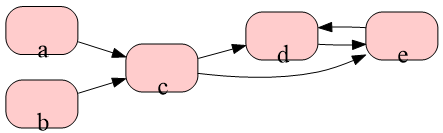

In [ ]:
G = pgv.AGraph(strict=False, directed=True)
G.graph_attr['rankdir'] = 'LR'
G.node_attr['shape'] = 'Mrecord'
for event, succesors in w_net.items():
  G.add_node(event, style="rounded,filled", fillcolor="#ffcccc")
  G.add_edges_from([(event, sc) for sc in succesors])
G.draw('simple_heuristic_net.png', prog='dot')
display(Image('simple_heuristic_net.png'))

## Udoskonalanie modelu procesu 

Aby lepiej zobrazować proces warto dodać odpowiednie kolory dla zadań \\
i zróżnicować grubości przepływów, w zależności od tego, \\
jak często w logu występowało odpowiednio dane zdarzenie albo przepływ. 

W tym celu potrzebujemy określić minimalne i maksymalne wartości:

In [ ]:
trace_counts = sorted(chain(*[c.values() for c in w_net.values()]))
print(trace_counts)
trace_min = trace_counts[0]
trace_max = trace_counts[-1]
color_min = ev_counter.min()
color_max = ev_counter.max()

[2, 2, 2, 2, 2, 2]


Teraz możemy do naszego modelu dodać zarówno kolory zadań, jak i grubości linii. \\
Ponadto dodamy do naszego modelu zdarzenie początkowe i zmienimy sposób wyświetlania \\
zarówno zdarzenia początkowego, jak i końcowego.

C:\Users\Filip\anaconda3\envs\Modelowanie\lib\site-packages\pygraphviz\agraph.py:1402: RuntimeWarning: Warning: Could not load "C:\Users\Filip\anaconda3\envs\Modelowanie\Library\bin\gvplugin_pango.dll" - It was found, so perhaps one of its dependents was not.  Try ldd.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


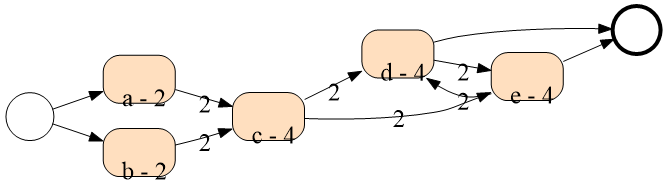

In [ ]:
 G = pgv.AGraph(strict= False, directed=True)
 G.graph_attr['rankdir'] = 'LR'
 G.node_attr['shape'] = 'Mrecord'

 G.add_node("start", shape="circle", label="")
 for ev_start in ev_start_set:
   G.add_edge("start", ev_start)

 for event, succesors in w_net.items():
  value = ev_counter[event]

  if float(trace_max-trace_min) == 0:
    color = int(80)
  else:
    color = int(float(trace_min-value)/float(trace_min-trace_max)*100.00)
    
  my_color = "#ff9933"+str(hex(color))[2:]
  G.add_node(event, style="rounded,filled", fillcolor=my_color, label=f'{event} - {value}')
  for succesor, cnt in succesors.items():
    if float(trace_max-trace_min) == 0:
      G.add_edge(event, succesor, penwidth=4*cnt/10000, label=cnt)
    else:
      G.add_edge(event, succesor, penwidth=4*cnt/(trace_max-trace_min), label=cnt)
 G.add_node("end", shape="circle", label="", penwidth='3')
 for ev_end in ev_end_set:
   G.add_edge(ev_end, "end")

 G.draw('simple_heuristic_net_with_events.png', prog='dot')
 display(Image('simple_heuristic_net_with_events.png'))

In [ ]:
# trace_counts = sorted(chain(*[c.values() for c in w_net.values()]))
# trace_min = trace_counts[0]
# trace_max = trace_counts[-1]
# color_min = avgTime.min()
# color_max = avgTime.max()

In [ ]:
#  G = pgv.AGraph(strict= False, directed=True)
#  G.graph_attr['rankdir'] = 'LR'
#  G.node_attr['shape'] = 'Mrecord'

#  G.add_node("start", shape="circle", label="")
#  for ev_start in ev_start_set:
#    G.add_edge("start", ev_start)

#  for event, succesors in w_net.items():
#   value = avgTime[event]

#   if float(color_min-color_max) == 0:
#     color = int(50)
#   else:
#     color = int(float(color_min-value)/float(color_min-color_max)*100.00)
    
#   my_color = "#ff9933"+str(hex(color))[2:]
#   G.add_node(event, style="rounded,filled", fillcolor=my_color, label=f'{event} - {value}')
#   for succesor, cnt in succesors.items():
#     if float(trace_max-trace_min) == 0:
#       G.add_edge(event, succesor, penwidth=4*cnt/10000, label=cnt)
#     else:
#       G.add_edge(event, succesor, penwidth=4*cnt/(trace_max-trace_min)+0.1, label=cnt)
#  G.add_node("end", shape="circle", label="", penwidth='3')
#  for ev_end in ev_end_set:
#    G.add_edge(ev_end, "end")

#  G.draw('simple_heuristic_net_with_events.png', prog='dot')
#  display(Image('simple_heuristic_net_with_events.png'))

#  print(filter1)
#  print(filter2)

NameError: name 'avgTime' is not defined

## Ćwiczenia rozszerzające model

1. Zmodyfikuj etykiety zadań w modelu, tak by dla każdego zadania oprócz nazwy wyświetlana była także liczba wystąpień odpowiadającego mu zdarzenia w logu. 
Dodaj opcję filtrowania (po zdarzeniach lub przepływach) w zależności od określonych progów, aby pokazać lub ukryć zadania lub przepływy zgodnie z wybranym progiem. Zaprezentuj modele dla wybranych progów np. 420 dla przepływów, 700 dla zdarzeń (osobno i razem). 

2. Dodaj możliwość ustawiania progów przez użytkownika (poprzez podanie liczby lub użycie suwaka z `ipywidgets`) i wyświetlania przefiltrowanego modelu. Przetestuj jego działanie na różnych progach, aby określić, czy model wygląda prawidłowo, w szczególności, czy jakieś zdania nie zostają odczepione od modelu lub nie są prawidłowo połączone z modelem, np. jeśli wcześniej zadanie występowało pomiędzy innymi zadaniami nie należy filtrować wszystkich przepływów, nawet jeśli są poniżej progu.

3. Zmodyfikuj progowanie, tak aby w takim wypadku zachować najlepszy przepływ, aby zadanie było połączone z pozostałymi co najmniej jednym wchodzącym i co najmniej jednym wychodzącym przepływem. Zaprezentuj modele po prostej filtracji i porównaj je z modelami po poprawionej filtracji.

4. Dodaj perspektywę wydajności, tzn. oblicz średni czas trwania i pokoloruj zadania zgodnie z czasem ich trwania, a przepływy odpowiedniej grubości.

5. Na podstawie obserwacji otrzymanego modelu, jakie wnioski można wyciągnąć z odkrytego procesu naprawy telefonów? Pomyśl o kilku wnioskach wynikających z obserwacji modelu i dotyczących odkrytego procesu, najlepiej takich, które nie są oczywiste, czy ogólne (dotyczące dowolnych modeli procesów).  

6. (*nadobowiązkowe*) Istnieją biblioteki do animowania grafów np. `GraphvizAnim`. Przy użyciu tego typu biblioteki można pokusić się o wyświetlenie animacji, jak przebiegał proces wg logu (podświetlając odpowiednie elementy). Jak może wyglądać bardzo zaawansowana animacja takiego modelu można zobaczyć w komercyjnym narzędziu [Disco](https://fluxicon.com/disco/).

Zadania mogą być realizowane w parach, natomiast w sprawozdaniu należy podać wtedy imiona i nazwiska osób z pary oraz każda osoba powinna wysłać zadanie/sprawozdanie przez system MS Teams osobno. 

W sprawozdaniu należy umieścić odpowiednie krótkie opisy z realizacji poszczególnych punktów, zrzuty ekranu oraz kod źródłowy (istotne fragmenty kodu ze zmianami). 

Sprawozdanie z wykonanych ćwiczeń należy przesłać przez platformę MS Teams do 24.03.2022 w postaci:
  - pdf z raportem o wykonaniu ćwiczeń,
  - ipynb z wykonanymi ćwiczeniami (pdf oraz ipynb).


## Dodatkowe informacje

Podobne modele, do tych odkrywanych w czasie laboratorium, można odkryć i eksplorować przy użyciu np. komercyjnego oprogramowania [Disco](https://fluxicon.com/disco/). Z kolei dużo więcej algorytmów i modeli jest zaimplementowanych w oprogramowaniu open-source [ProM](http://www.promtools.org/), jednakże jego obsługa jest dość skomplikowana.

Dziękuję za udział w zajęciach! \\
Krzysztof Kluza \\
kluza@agh.edu.pl
